In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
"""
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

'\nimport numpy as np # linear algebra\nimport pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)\n\n# Input data files are available in the read-only "../input/" directory\n# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory\n\nimport os\nfor dirname, _, filenames in os.walk(\'/kaggle/input\'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n'

In [2]:
import pandas as pd

In [3]:
import os
import shutil

dest_folder="/kaggle/working/data/"
if os.path.exists(dest_folder):
    shutil.rmtree(dest_folder)
    print(f"Directory '{dest_folder}' and its contents deleted successfully.")
else:
    print(f"Directory '{dest_folder}' does not exist.")


Directory '/kaggle/working/data/' does not exist.


In [4]:
df_meta = pd.read_csv("/kaggle/input/data/Data_Entry_2017.csv")

In [5]:
import numpy as np

In [6]:
df_meta["Finding Labels"] = df_meta["Finding Labels"].astype(str).str.strip()
df_meta["Image Index"] = df_meta["Image Index"].astype(str).str.strip()


# Coerce age to numeric and cap to a plausible range
df_meta["Patient Age"] = pd.to_numeric(df_meta.get("Patient Age", np.nan), errors="coerce")
df_meta.loc[(df_meta["Patient Age"] < 0) | (df_meta["Patient Age"] > 120), "Patient Age"] = np.nan

# Standardize gender values (M/F)
if "Patient Gender" in df_meta.columns:
    df_meta["Patient Gender"] = df_meta["Patient Gender"].astype(str).str.upper().str.strip()
    df_meta.loc[~df_meta["Patient Gender"].isin(["M","F"]), "Patient Gender"] = np.nan

In [7]:
import glob
import os
IMAGE_GLOB = "/kaggle/input/data/images_*/images/*.png"
image_paths = glob.glob(IMAGE_GLOB)
fname_to_path = {os.path.basename(p): p for p in image_paths}

print("Total images found on disk:", len(image_paths))

# Coverage vs CSV
in_disk_mask = df_meta["Image Index"].isin(fname_to_path)
missing_files = (~in_disk_mask).sum()
print("CSV images missing on disk:", missing_files)

# Attach a column with resolved full path (NaN if missing)
df_meta["image_path"] = df_meta["Image Index"].map(fname_to_path)
df_meta.head()

Total images found on disk: 112120
CSV images missing on disk: 0


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,image_path
0,00000001_000.png,Cardiomegaly,0,1,58.0,M,PA,2682,2749,0.143,0.143,NaN,/kaggle/input/data/images_001/images/00000001_...
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58.0,M,PA,2894,2729,0.143,0.143,NaN,/kaggle/input/data/images_001/images/00000001_...
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58.0,M,PA,2500,2048,0.168,0.168,NaN,/kaggle/input/data/images_001/images/00000001_...
3,00000002_000.png,No Finding,0,2,81.0,M,PA,2500,2048,0.171,0.171,NaN,/kaggle/input/data/images_001/images/00000002_...
4,00000003_000.png,Hernia,0,3,81.0,F,PA,2582,2991,0.143,0.143,NaN,/kaggle/input/data/images_001/images/00000003_...


In [8]:
# Split multi-label string to list
df_meta["label_list"] = df_meta["Finding Labels"].fillna("No Finding").str.split("|")

# Number of labels per image
df_meta["n_labels"] = df_meta["label_list"].apply(len)

# Explode to one label per row for easier counting
df_long = df_meta.explode("label_list").rename(columns={"label_list": "Label"})
df_long["Label"] = df_long["Label"].str.strip()
df_long.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,image_path,Label,n_labels
0,00000001_000.png,Cardiomegaly,0,1,58.0,M,PA,2682,2749,0.143,0.143,NaN,/kaggle/input/data/images_001/images/00000001_...,Cardiomegaly,1
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58.0,M,PA,2894,2729,0.143,0.143,NaN,/kaggle/input/data/images_001/images/00000001_...,Cardiomegaly,2
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58.0,M,PA,2894,2729,0.143,0.143,NaN,/kaggle/input/data/images_001/images/00000001_...,Emphysema,2
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58.0,M,PA,2500,2048,0.168,0.168,NaN,/kaggle/input/data/images_001/images/00000001_...,Cardiomegaly,2
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58.0,M,PA,2500,2048,0.168,0.168,NaN,/kaggle/input/data/images_001/images/00000001_...,Effusion,2


In [9]:
df_long.drop("Unnamed: 11", axis=1, inplace=True)

In [10]:
target_labels = df_long["Label"].unique()

In [11]:
df_target = df_long.drop("Label", axis=1)

In [12]:
df_target.drop_duplicates(inplace = True)

In [13]:
df_target["Diseases"] = df_target["Finding Labels"].apply(
    lambda x: [i.strip() for i in x.split("|")]
)


In [14]:
df_final = df_target[["Patient Age","Patient Gender", "image_path", "Diseases", "Image Index","Patient ID"]]

In [15]:
### ranges

def get_age_class(val):
    if val < 25:
        return 1
    elif val >=25 and val <40:
        return 2
    elif val >=40 and val<65:
        return 3
    else:
        return 4

In [16]:
df_final["Patient Age"] = df_final["Patient Age"].apply(get_age_class)

/tmp/ipykernel_13/2279100602.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["Patient Age"] = df_final["Patient Age"].apply(get_age_class)


In [17]:
df_final.head()

,Patient Age,Patient Gender,image_path,Diseases,Image Index,Patient ID
0,3,M,/kaggle/input/data/images_001/images/00000001_...,[Cardiomegaly],00000001_000.png,1
1,3,M,/kaggle/input/data/images_001/images/00000001_...,"[Cardiomegaly, Emphysema]",00000001_001.png,1
2,3,M,/kaggle/input/data/images_001/images/00000001_...,"[Cardiomegaly, Effusion]",00000001_002.png,1
3,4,M,/kaggle/input/data/images_001/images/00000002_...,[No Finding],00000002_000.png,2
4,4,F,/kaggle/input/data/images_001/images/00000003_...,[Hernia],00000003_000.png,3


In [18]:
no_finding_df = df_final[df_final['Diseases'].apply(lambda x: x[0]=="No Finding")]

In [19]:
len(no_finding_df)

60361

In [20]:
df_final_without_no_finding = df_final.drop(no_finding_df.index)

In [21]:
no_finding_df = no_finding_df.drop_duplicates("Patient ID")

In [22]:
no_finding_df.groupby(["Patient Age","Patient Gender"])["Patient ID"].count()

Patient Age  Patient Gender
1            F                 1415
             M                 1690
2            F                 2862
             M                 3020
3            F                 6043
             M                 6940
4            F                 1105
             M                 1832
Name: Patient ID, dtype: int64

In [23]:
target_no_finding = int(len(df_final_without_no_finding) * 0.12)  # or 0.8, 1.2 etc.

# check age-gender distribution for reference
dist = (
    no_finding_df.groupby(["Patient Age", "Patient Gender"])
    .size()
    .reset_index(name="Count")
)

total_no_finding = dist["Count"].sum()
dist["Sample_Count"] = (dist["Count"] / total_no_finding * target_no_finding).round().astype(int)

undersampled = []
for _, row in dist.iterrows():
    subset = no_finding_df[
        (no_finding_df["Patient Age"] == row["Patient Age"]) &
        (no_finding_df["Patient Gender"] == row["Patient Gender"])
    ]
    sampled = subset.sample(
        n=min(len(subset), row["Sample_Count"]),
        random_state=42,
        replace=False
    )
    undersampled.append(sampled)

no_finding_undersampled_df = pd.concat(undersampled, ignore_index=True)

In [24]:
len(no_finding_undersampled_df)

6212

In [25]:
df_final = pd.concat([no_finding_undersampled_df, df_final_without_no_finding], ignore_index=True)
df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

In [26]:
df_final

,Patient Age,Patient Gender,image_path,Diseases,Image Index,Patient ID
0,3,M,/kaggle/input/data/images_009/images/00020058_...,[Infiltration],00020058_000.png,20058
1,3,M,/kaggle/input/data/images_007/images/00014607_...,[Mass],00014607_002.png,14607
2,3,M,/kaggle/input/data/images_003/images/00003985_...,[Emphysema],00003985_000.png,3985
3,3,M,/kaggle/input/data/images_012/images/00029976_...,"[Atelectasis, Pleural_Thickening]",00029976_000.png,29976
4,3,M,/kaggle/input/data/images_008/images/00018145_...,"[Infiltration, Nodule]",00018145_003.png,18145
...,...,...,...,...,...,...
57966,2,F,/kaggle/input/data/images_011/images/00028013_...,"[Effusion, Pleural_Thickening]",00028013_012.png,28013
57967,3,M,/kaggle/input/data/images_008/images/00017691_...,[Effusion],00017691_014.png,17691
57968,2,F,/kaggle/input/data/images_012/images/00028214_...,[No Finding],00028214_000.png,28214
57969,2,M,/kaggle/input/data/images_003/images/00006068_...,[Infiltration],00006068_007.png,6068


In [27]:
import numpy as np

In [28]:
with open("/kaggle/input/data/train_val_list.txt") as train_val_txt:
  train_val_indices = np.array(train_val_txt.read().split("\n"))
train_val_indices

array(['00000001_000.png', '00000001_001.png', '00000001_002.png', ...,
       '00030795_000.png', '00030801_000.png', '00030801_001.png'],
      dtype='<U16')

In [29]:
features_train = df_meta[df_meta["Image Index"].isin(train_val_indices)]["Image Index"].values

In [30]:
features_train

array(['00000001_000.png', '00000001_001.png', '00000001_002.png', ...,
       '00030795_000.png', '00030801_000.png', '00030801_001.png'],
      dtype=object)

In [31]:
df_train = df_final[df_final["Image Index"].isin(features_train)]

In [32]:
len(df_train)

41610

In [33]:
from sklearn.preprocessing import MultiLabelBinarizer

# Original 15 labels
target_labels = [
    'Emphysema', 'Infiltration', 'Pleural_Thickening', 'Pneumothorax',
    'Cardiomegaly', 'No Finding', 'Atelectasis', 'Edema', 'Effusion',
    'Consolidation', 'Mass', 'Nodule', 'Fibrosis', 'Pneumonia', 'Hernia'
]

# Remove "No Finding"
target_labels = [cls for cls in target_labels if cls != "No Finding"]

mlb = MultiLabelBinarizer(classes=target_labels)
encoded = mlb.fit_transform(df_train["Diseases"])

df_train["Encoded"] = encoded.tolist()

# Keep only useful columns
df_train = df_train[["image_path", "Diseases", "Encoded","Patient Age", "Patient Gender", "Image Index"]]

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['No Finding'] will be ignored
  warnings.warn(
/tmp/ipykernel_13/1361652371.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["Encoded"] = encoded.tolist()


In [34]:
df_train.head()

,image_path,Diseases,Encoded,Patient Age,Patient Gender,Image Index
0,/kaggle/input/data/images_009/images/00020058_...,[Infiltration],"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",3,M,00020058_000.png
2,/kaggle/input/data/images_003/images/00003985_...,[Emphysema],"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",3,M,00003985_000.png
3,/kaggle/input/data/images_012/images/00029976_...,"[Atelectasis, Pleural_Thickening]","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",3,M,00029976_000.png
4,/kaggle/input/data/images_008/images/00018145_...,"[Infiltration, Nodule]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",3,M,00018145_003.png
5,/kaggle/input/data/images_007/images/00015128_...,[Effusion],"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",3,F,00015128_000.png


In [35]:
from skmultilearn.model_selection import iterative_train_test_split
import numpy as np
import pandas as pd

# --- Prepare input arrays ---
y = np.stack(df_train["Encoded"].values)        # shape: (n_samples, n_labels)
X = df_train.drop(columns=["Encoded"]).to_numpy()

# --- Perform iterative stratified split ---
X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size=0.5)

# --- Convert back to DataFrames ---
base_cols = list(df_train.drop(columns=["Encoded"]).columns)
num_labels = y.shape[1]                         # will be 14 now
label_cols = list(range(num_labels))            # [0 ... 13]

# TRAIN
df_train_final = pd.DataFrame(
    np.hstack([X_train, y_train]),
    columns=base_cols + label_cols
)
df_train_final["Encoded"] = df_train_final[label_cols].values.tolist()
df_train_final.drop(columns=label_cols, inplace=True)

# VAL
df_val_final = pd.DataFrame(
    np.hstack([X_test, y_test]),
    columns=base_cols + label_cols
)
df_val_final["Encoded"] = df_val_final[label_cols].values.tolist()
df_val_final.drop(columns=label_cols, inplace=True)

print(f"Train shape: {df_train_final.shape} | Val shape: {df_val_final.shape}")


Train shape: (20805, 6) | Val shape: (20805, 6)


In [36]:
len(df_train_final)

20805

In [37]:
train_images = df_train_final["image_path"].tolist()

In [38]:
df_train_final.head()

,image_path,Diseases,Patient Age,Patient Gender,Image Index,Encoded
0,/kaggle/input/data/images_009/images/00020058_...,[Infiltration],3,M,00020058_000.png,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,/kaggle/input/data/images_012/images/00029976_...,"[Atelectasis, Pleural_Thickening]",3,M,00029976_000.png,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
2,/kaggle/input/data/images_008/images/00018145_...,"[Infiltration, Nodule]",3,M,00018145_003.png,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
3,/kaggle/input/data/images_005/images/00010953_...,[Effusion],3,F,00010953_002.png,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
4,/kaggle/input/data/images_010/images/00021212_...,[Emphysema],2,F,00021212_009.png,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [39]:
os.mkdir("/kaggle/working/data/")

In [40]:
import os
import shutil
from tqdm import tqdm

dest_folder="/kaggle/working/data/train_data/"


os.mkdir(dest_folder)

for train_image in tqdm(train_images):
    shutil.copyfile(train_image, dest_folder+train_image.split("/")[-1])

100%|██████████| 20805/20805 [05:09<00:00, 67.30it/s]


In [41]:
target_labels

['Emphysema',
 'Infiltration',
 'Pleural_Thickening',
 'Pneumothorax',
 'Cardiomegaly',
 'Atelectasis',
 'Edema',
 'Effusion',
 'Consolidation',
 'Mass',
 'Nodule',
 'Fibrosis',
 'Pneumonia',
 'Hernia']

In [42]:
import json

In [43]:
data = {
    "diseases" : target_labels
}

In [44]:
with open("/kaggle/working/data/disease_details.json", "w") as f:
    json.dump(data, f)

In [45]:
df_train_final.drop("image_path", axis=1, inplace=True)

In [46]:
df_train_final.head()

,Diseases,Patient Age,Patient Gender,Image Index,Encoded
0,[Infiltration],3,M,00020058_000.png,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,"[Atelectasis, Pleural_Thickening]",3,M,00029976_000.png,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
2,"[Infiltration, Nodule]",3,M,00018145_003.png,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
3,[Effusion],3,F,00010953_002.png,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
4,[Emphysema],2,F,00021212_009.png,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [47]:
df_train_final.to_csv("/kaggle/working/data/train_meta_data.csv",index=False)

In [48]:
!zip -r /kaggle/working/data_train.zip /kaggle/working/data/ 

  adding: kaggle/working/data/ (stored 0%)
  adding: kaggle/working/data/disease_details.json (deflated 30%)
  adding: kaggle/working/data/train_data/ (stored 0%)
  adding: kaggle/working/data/train_data/00023726_000.png (deflated 0%)
  adding: kaggle/working/data/train_data/00003737_002.png (deflated 0%)
  adding: kaggle/working/data/train_data/00004564_000.png (deflated 0%)
  adding: kaggle/working/data/train_data/00019558_000.png (deflated 0%)
  adding: kaggle/working/data/train_data/00007209_001.png (deflated 0%)
  adding: kaggle/working/data/train_data/00016958_000.png (deflated 0%)
  adding: kaggle/working/data/train_data/00012649_011.png (deflated 0%)
  adding: kaggle/working/data/train_data/00028419_000.png (deflated 0%)
  adding: kaggle/working/data/train_data/00001395_003.png (deflated 0%)
  adding: kaggle/working/data/train_data/00024682_000.png (deflated 0%)
  adding: kaggle/working/data/train_data/00009604_006.png (deflated 0%)
  adding: kaggle/working/data/train_data/0001

In [49]:
import os
import shutil

dest_folder="/kaggle/working/data/train_data"
if os.path.exists(dest_folder):
    shutil.rmtree(dest_folder)
    print(f"Directory '{dest_folder}' and its contents deleted successfully.")
else:
    print(f"Directory '{dest_folder}' does not exist.")

if os.path.exists("/kaggle/working/data/train_meta_data.csv"):
    os.remove("/kaggle/working/data/train_meta_data.csv")
    print("Deleted: /kaggle/working/data/train_meta_data.csv")
else:
    print("File not found.")


if os.path.exists("/kaggle/working/data/disease_details.json"):
    os.remove("/kaggle/working/data/disease_details.json")
    print("Deleted: /kaggle/working/data/disease_details.json")
else:
    print("File not found.")


Directory '/kaggle/working/data/train_data' and its contents deleted successfully.
Deleted: /kaggle/working/data/train_meta_data.csv
Deleted: /kaggle/working/data/disease_details.json


In [50]:
df_train_final["label_list"] = df_train_final["Diseases"]

# Number of labels per image
df_train_final["n_labels"] = df_train_final["label_list"].apply(len)

# Explode to one label per row for easier counting
df_train_final = df_train_final.explode("label_list").rename(columns={"label_list": "Label"})
df_train_final["Label"] = df_train_final["Label"].str.strip()
df_train_final.head()

,Diseases,Patient Age,Patient Gender,Image Index,Encoded,Label,n_labels
0,[Infiltration],3,M,00020058_000.png,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",Infiltration,1
1,"[Atelectasis, Pleural_Thickening]",3,M,00029976_000.png,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",Atelectasis,2
1,"[Atelectasis, Pleural_Thickening]",3,M,00029976_000.png,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",Pleural_Thickening,2
2,"[Infiltration, Nodule]",3,M,00018145_003.png,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",Infiltration,2
2,"[Infiltration, Nodule]",3,M,00018145_003.png,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",Nodule,2


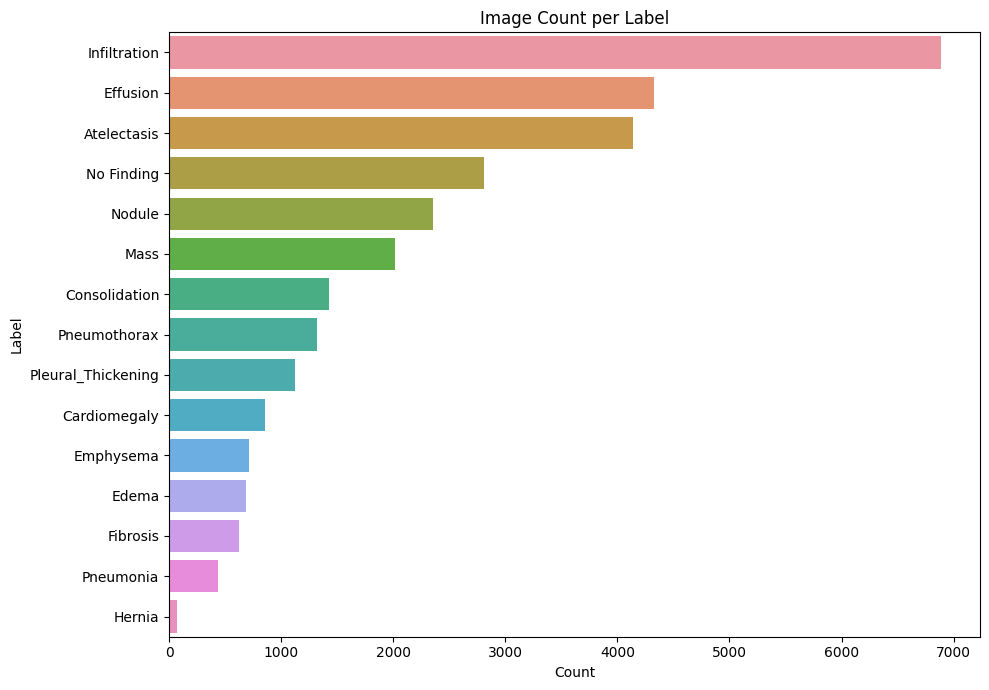

Label
Infiltration          6891
Effusion              4329
Atelectasis           4140
No Finding            2809
Nodule                2354
Mass                  2017
Consolidation         1426
Pneumothorax          1318
Pleural_Thickening    1121
Cardiomegaly           854
Name: count, dtype: int64

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

label_counts = df_train_final["Label"].value_counts()

plt.figure(figsize=(10, 7))
sns.barplot(x=label_counts.values, y=label_counts.index)
plt.title("Image Count per Label")
plt.xlabel("Count")
plt.ylabel("Label")
plt.tight_layout()
plt.show()

# Top 10 labels table
label_counts.head(10)

In [52]:
df_bbox = pd.read_csv("/kaggle/input/data/BBox_List_2017.csv")

In [53]:
df_bbox.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN


In [54]:
len(df_bbox)

984

In [55]:
with open("/kaggle/input/data/test_list.txt") as test_txt:
  test_indices = np.array(test_txt.read().split("\n"))
test_indices

array(['00000003_000.png', '00000003_001.png', '00000003_002.png', ...,
       '00030803_000.png', '00030804_000.png', '00030805_000.png'],
      dtype='<U16')

In [56]:
df_bbox.drop(["Unnamed: 6","Unnamed: 7","Unnamed: 8"], axis=1, inplace=True)

In [57]:
features_test = df_final[df_final["Image Index"].isin(test_indices)]["Image Index"].values

In [58]:
df_bbox_train = df_bbox[df_bbox["Image Index"].isin(features_test)]

In [59]:
len(df_bbox_train)

984

In [60]:
import glob
import os
IMAGE_GLOB = "/kaggle/input/data/images_*/images/*.png"
image_paths = glob.glob(IMAGE_GLOB)
fname_to_path = {os.path.basename(p): p for p in image_paths}

print("Total images found on disk:", len(image_paths))

# Coverage vs CSV
in_disk_mask = df_meta["Image Index"].isin(fname_to_path)
missing_files = (~in_disk_mask).sum()
print("CSV images missing on disk:", missing_files)

# Attach a column with resolved full path (NaN if missing)
df_bbox_train["image_path"] = df_bbox_train["Image Index"].map(fname_to_path)
df_bbox_train.head()

Total images found on disk: 112120
CSV images missing on disk: 0


,Image Index,Finding Label,Bbox [x,y,w,h],image_path
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,/kaggle/input/data/images_006/images/00013118_...
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,/kaggle/input/data/images_007/images/00014716_...
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,/kaggle/input/data/images_012/images/00029817_...
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,/kaggle/input/data/images_007/images/00014687_...
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,/kaggle/input/data/images_008/images/00017877_...


In [61]:
df_train.head()

,image_path,Diseases,Encoded,Patient Age,Patient Gender,Image Index
0,/kaggle/input/data/images_009/images/00020058_...,[Infiltration],"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",3,M,00020058_000.png
2,/kaggle/input/data/images_003/images/00003985_...,[Emphysema],"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",3,M,00003985_000.png
3,/kaggle/input/data/images_012/images/00029976_...,"[Atelectasis, Pleural_Thickening]","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",3,M,00029976_000.png
4,/kaggle/input/data/images_008/images/00018145_...,"[Infiltration, Nodule]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",3,M,00018145_003.png
5,/kaggle/input/data/images_007/images/00015128_...,[Effusion],"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",3,F,00015128_000.png


In [62]:
train_images = df_train["image_path"].tolist()

In [63]:
bbox_images = df_bbox_train["image_path"].tolist()

In [64]:
import os
import shutil
from tqdm import tqdm

dest_folder="/kaggle/working/data/bbox_images/"


os.mkdir(dest_folder)

for bbox_image in tqdm(bbox_images):
    shutil.copyfile(bbox_image, dest_folder+bbox_image.split("/")[-1])

100%|██████████| 984/984 [00:11<00:00, 85.72it/s] 


In [65]:
df_bbox_train.head()

,Image Index,Finding Label,Bbox [x,y,w,h],image_path
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,/kaggle/input/data/images_006/images/00013118_...
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,/kaggle/input/data/images_007/images/00014716_...
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,/kaggle/input/data/images_012/images/00029817_...
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,/kaggle/input/data/images_007/images/00014687_...
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,/kaggle/input/data/images_008/images/00017877_...


In [66]:
df_bbox_train.drop("image_path", axis=1, inplace=True)

In [67]:
df_bbox_train.head()

,Image Index,Finding Label,Bbox [x,y,w,h]
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695


In [68]:
df_bbox_train.to_csv("/kaggle/working/data/bbox_metadata.csv", index=False)

In [69]:
!zip -r /kaggle/working/bbox_check.zip /kaggle/working/data/ 

  adding: kaggle/working/data/ (stored 0%)
  adding: kaggle/working/data/bbox_images/ (stored 0%)
  adding: kaggle/working/data/bbox_images/00026889_000.png (deflated 0%)
  adding: kaggle/working/data/bbox_images/00016291_019.png (deflated 0%)
  adding: kaggle/working/data/bbox_images/00010828_023.png (deflated 0%)
  adding: kaggle/working/data/bbox_images/00000149_006.png (deflated 0%)
  adding: kaggle/working/data/bbox_images/00021181_002.png (deflated 0%)
  adding: kaggle/working/data/bbox_images/00020408_037.png (deflated 0%)
  adding: kaggle/working/data/bbox_images/00018412_001.png (deflated 0%)
  adding: kaggle/working/data/bbox_images/00002350_001.png (deflated 0%)
  adding: kaggle/working/data/bbox_images/00007735_040.png (deflated 0%)
  adding: kaggle/working/data/bbox_images/00022215_011.png (deflated 0%)
  adding: kaggle/working/data/bbox_images/00028774_047.png (deflated 0%)
  adding: kaggle/working/data/bbox_images/00027474_005.png (deflated 0%)
  adding: kaggle/working/d

In [70]:
import os
import shutil

dest_folder="/kaggle/working/data/bbox_images"
if os.path.exists(dest_folder):
    shutil.rmtree(dest_folder)
    print(f"Directory '{dest_folder}' and its contents deleted successfully.")
else:
    print(f"Directory '{dest_folder}' does not exist.")

if os.path.exists("/kaggle/working/data/bbox_metadata.csv"):
    os.remove("/kaggle/working/data/bbox_metadata.csv")
    print("Deleted: /kaggle/working/data/bbox_metadata.csv")
else:
    print("File not found.")


Directory '/kaggle/working/data/bbox_images' and its contents deleted successfully.
Deleted: /kaggle/working/data/bbox_metadata.csv


In [71]:
import os
import shutil

dest_folder="/kaggle/working/data/"
if os.path.exists(dest_folder):
    shutil.rmtree(dest_folder)
    print(f"Directory '{dest_folder}' and its contents deleted successfully.")
else:
    print(f"Directory '{dest_folder}' does not exist.")

Directory '/kaggle/working/data/' and its contents deleted successfully.
